In [17]:
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from scipy.spatial import distance
from sklearn.cluster import AgglomerativeClustering

import warnings
import os
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore"

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


In [5]:
df = pd.read_csv("../preprocessed_data/preprocessed_train.csv")

# PCA

In [6]:
def plot_variance_content(df):
    pca = PCA()
    pca.fit(df)
    variance_ratio = pca.explained_variance_ratio_
    x = np.arange(len(variance_ratio))

    plt.bar(x, variance_ratio)
    plt.xlabel('Kolumny')
    plt.ylabel('Zawarta wariancja')
    plt.xticks(x)
    plt.show()

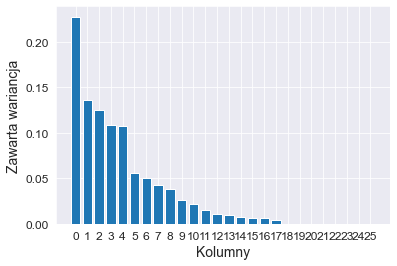

In [7]:
plot_variance_content(df)

In [8]:
def plot_explained_variance(data, variance_ratio_threshold=0.95, max_columns=15):

    pca = PCA()
    pca.fit(data)

    variance_ratio = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(variance_ratio)
    x = np.arange(1, len(variance_ratio) + 1)

    if max_columns:
        cumulative_variance = cumulative_variance[:max_columns]
        x = x[:max_columns]

    plt.plot(x, cumulative_variance, marker='o', linestyle='-', color='b')
    plt.xlabel('Liczba kolumn')
    plt.ylabel('Skumulowana wariancja wyjaśniona')
    plt.grid(True)

    if variance_ratio_threshold:
        plt.axhline(y=variance_ratio_threshold, color='r', linestyle='--')
        intersection_idx = np.argmax(cumulative_variance >= variance_ratio_threshold)
        plt.axvline(x=intersection_idx+1, color='black', linestyle='--')

    plt.show()


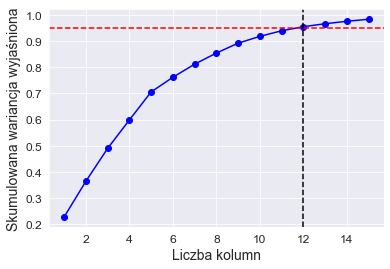

In [9]:
plot_explained_variance(df, 0.95)

In [10]:
df_pca_processed = pd.DataFrame(PCA(n_components = 12).fit_transform(df))

In [59]:
from sklearn.manifold import TSNE
import seaborn as sns

def scatter(x, colors):
    palette = np.array(sns.color_palette("hls", 10))

    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # add labels
    txts = []
    for i in range(10):
        # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txts.append(txt)

    return f, ax, sc, txts



(<Figure size 576x576 with 1 Axes>,
 <AxesSubplot:>,
 [Text(75.94458, 5.416341, '0'),
  Text(-12.847364, -1.1152182, '1'),
  Text(nan, nan, '2'),
  Text(nan, nan, '3'),
  Text(nan, nan, '4'),
  Text(nan, nan, '5'),
  Text(nan, nan, '6'),
  Text(nan, nan, '7'),
  Text(nan, nan, '8'),
  Text(nan, nan, '9')])

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


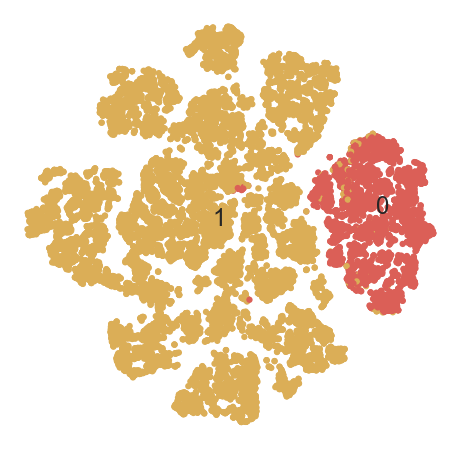

In [60]:
from sklearn.cluster import KMeans

digits_proj = TSNE(random_state=42).fit_transform(df_pca_processed)
scatter(digits_proj, KMeans(n_clusters=2).fit_predict(df_pca_processed))

In [12]:
def plot_clusters(X, model, fit_predict):
    if fit_predict:
        y_pred = model.fit_predict(X)
    else:
        y_pred = model.predict(X)

    ax1 = plt.axes(projection='3d')
    ax1.scatter3D(X.iloc[:,0], X.iloc[:,1], X.iloc[:,2], c=y_pred)
    plt.show()

    ax1 = plt.axes(projection='3d')
    ax1.view_init(90,0)
    ax1.scatter3D(X.iloc[:,0], X.iloc[:,1], X.iloc[:,2], c=y_pred)
    plt.show()

    ax1 = plt.axes(projection='3d')
    ax1.view_init(0,90)
    ax1.scatter3D(X.iloc[:,0], X.iloc[:,1], X.iloc[:,2], c=y_pred)
    plt.show()

# Agglomerative clustering

Clusters from agglomerative clustering with single linkage


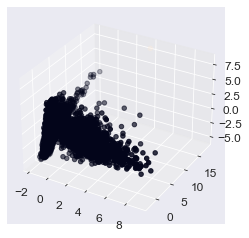

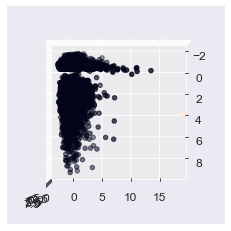

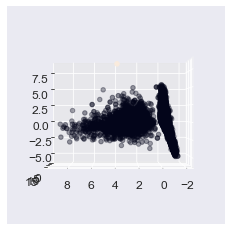

Clusters from agglomerative clustering with complete linkage


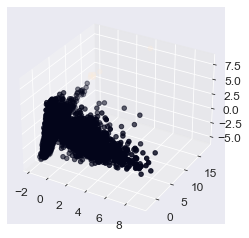

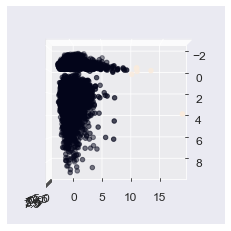

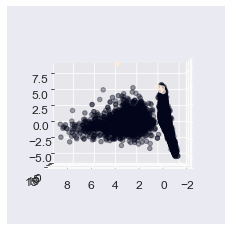

Clusters from agglomerative clustering with average linkage


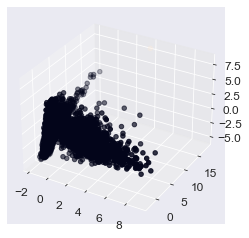

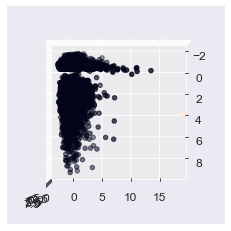

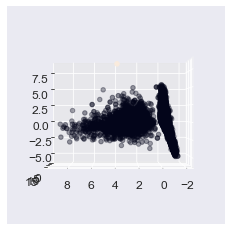

Clusters from agglomerative clustering with ward linkage


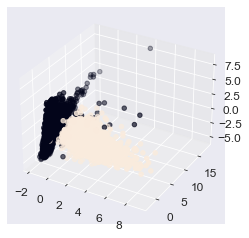

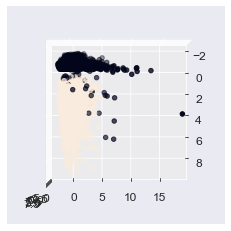

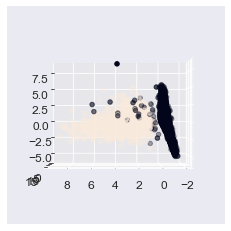

In [13]:
for linkage in {'ward', 'complete', 'average', 'single'}:
    print(f'Clusters from agglomerative clustering with {linkage} linkage')
    plot_clusters(df_pca_processed, AgglomerativeClustering(n_clusters=2, linkage=linkage), True)

In [49]:
def count_clustering_scores(X, model, score_fun):

    X = X.to_numpy()
    model_instance = model
    labels = model_instance.fit_predict(X)

    return score_fun(X, labels)

def min_interclust_dist(X, label):
    clusters = set(label)
    global_min_dist = np.inf
    for cluster_i in clusters:
        cluster_i_idx = np.where(label == cluster_i)
        for cluster_j in clusters:
            if cluster_i != cluster_j:
                cluster_j_idx = np.where(label == cluster_j)
                interclust_min_dist = np.min(distance.cdist(X[cluster_i_idx], X[cluster_j_idx]))
                global_min_dist = np.min([global_min_dist, interclust_min_dist])
    return global_min_dist

def _inclust_mean_dists(X, label):
    clusters = set(label)
    inclust_dist_list = []
    for cluster_i in clusters:
        cluster_i_idx = np.where(label == cluster_i)
        inclust_dist = np.mean(distance.pdist(X[cluster_i_idx]))
        inclust_dist_list.append(inclust_dist)
    return inclust_dist_list

def mean_inclust_dist(X, label):
    inclust_dist_list = _inclust_mean_dists(X, label)
    return np.mean(inclust_dist_list)

def std_dev_of_inclust_dist(X, label):
    inclust_dist_list = _inclust_mean_dists(X, label)
    return np.std(inclust_dist_list)

def mean_dist_to_center(X, label):
    clusters = set(label)
    inclust_dist_list = []
    for cluster_i in clusters:
        cluster_i_idx = np.where(label == cluster_i)
        cluster_i_mean = np.mean(X[cluster_i_idx], axis=0, keepdims=True)
        inclust_dist = np.mean(distance.cdist(X[cluster_i_idx], cluster_i_mean))
        inclust_dist_list.append(inclust_dist)
    return np.mean(inclust_dist_list)

In [50]:
from sklearn.metrics import silhouette_score
import pandas as pd

metrices = {
    'min dist between clusters': min_interclust_dist,
    'mean dist in clust': mean_inclust_dist,
    'std dev dist in clust': std_dev_of_inclust_dist,
    'mean dist to clust center': mean_dist_to_center,
    'silhouette': silhouette_score
}

models = {
    'Agglomerative ward linkage': AgglomerativeClustering(n_clusters=2, linkage='ward'),
    'Agglomerative complete linkage': AgglomerativeClustering(n_clusters=2, linkage='complete'),
    'Agglomerative average linkage': AgglomerativeClustering(n_clusters=2, linkage='average'),
    'Agglomerative single linkage': AgglomerativeClustering(n_clusters=2, linkage='single'),
}

df = pd.DataFrame()
for model_key in models:
    for metric_key in metrices:
        df.loc[model_key, metric_key] = count_clustering_scores(X=df_pca_processed,model=models[model_key],
                                                                score_fun=metrices[metric_key])
df

,min dist between clusters,mean dist in clust,std dev dist in clust,mean dist to clust center,silhouette
Agglomerative ward linkage,0.928113,3.526179,0.359383,2.466052,0.325829
Agglomerative complete linkage,4.154811,4.825659,1.139018,3.186536,0.823524
Agglomerative average linkage,8.175224,NaN,NaN,1.285424,0.867966
Agglomerative single linkage,8.175224,NaN,NaN,1.285424,0.867966
